In [51]:
%matplotlib inline
import pylab as plt
import numpy as np
from astrometry.util.fits import *
from astrometry.util.util import Tan,Sip
from glob import glob
import fitsio
import sys
import os
import matplotlib
import tractor
from tractor.constrained_optimizer import *
matplotlib.rcParams['figure.figsize'] = 10,8
from scipy.ndimage.filters import gaussian_filter

In [9]:
# GFA Metrology results -- GFA#10
# https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=4832
# Images --
# https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=4832;filename=GFA%2310_GIF-Metrology-images.zip;version=2    

In [233]:
def blanton_noise(img):
    # Estimate per-pixel noise via Blanton's 5-pixel MAD
    slice1 = (slice(0,-5,10),slice(0,-5,10))
    slice2 = (slice(5,None,10),slice(5,None,10))
    mad = np.median(np.abs(img[slice1] - img[slice2]).ravel())
    sig1 = 1.4826 * mad / np.sqrt(2.)
    return sig1

def measure_gfa_spots(imgdir, ss_text, plots=True, chatty=True):
    rows = [row for row in ss_text.split('\n') if len(row.strip())>0]
    words = [row.strip().split('\t') for row in rows]

    def chat(*X):
        if chatty:
            print(*X)

    G = fits_table()
            
    bgfn = words[0][0]
    words = words[1:]
    G.img_fn = np.array([w[2] for w in words])
    G.mmx = np.array([float(w[0]) for w in words])
    G.mmy = np.array([float(w[1]) for w in words])
    G.orig_ssx = np.array([float(w[5]) for w in words])
    G.orig_ssy = np.array([float(w[6]) for w in words])

    G.measx = np.zeros(len(G))
    G.measy = np.zeros(len(G))
    G.prescan = np.zeros(len(G))
    G.overscan = np.zeros(len(G))
    G.quadrant = np.zeros(len(G), np.uint8)
    
    bg = os.path.join(imgdir, bgfn)
    Fbg = fitsio.FITS(bg)
    bgimgs = [Fbg[i].read() for i in range(1,5)]
    ima = dict(interpolation='nearest', origin='lower')
    
    all_coords = []

    for iimg,imgfn in enumerate(G.img_fn):
        chat()
        chat('Image', imgfn)
        fn = os.path.join(imgdir, imgfn) #'IMG_%i.fits' % imgnum)
        F = fitsio.FITS(fn)
        hdr = F[0].read_header()
        prescan = hdr['PRESCAN']
        overscan = hdr['OVERSCAN']
        #print('Prescan', prescan, 'overscan', overscan)
        for q in range(4):
            img = F[q+1].read()
            hi,wi = img.shape
            active = (img - bgimgs[q])[:, prescan:-overscan]
            #print('Active area:', active.shape)

            active = active - np.median(active)
            ah,aw = active.shape
            sig1 = blanton_noise(active)

            # Mask 8 bad rows at the bottom
            active[:8,:] = 0.
            
            smoo = gaussian_filter(active, 2.)
            noise = blanton_noise(smoo)
            maxsn = np.max(smoo/noise)
            chat('S/N', maxsn)
            imax = np.argmax(smoo/noise)
            i,j = np.unravel_index(imax, smoo.shape)

            if plots:
                plt.clf()
                plt.imshow(active, vmin=-3.*sig1, vmax=20.*sig1, **ima)
                ax = plt.axis()
                plt.plot(j, i, 'o', mec='r', ms=20, mfc='none')
                plt.show()
            
            if maxsn < 1000:
                continue
            chat('At', j,i)
            if i<10 or j<10:
                chat('Too close to edge')
                continue
            cutout = active[i-10:i+11, j-10:j+11]

            SAT = 25000
        
            satur = (cutout > SAT)
            inverr = np.ones_like(cutout) / sig1
            inverr[satur] = 0.
        
            tim = tractor.Image(data=cutout, inverr=inverr,
                               psf=tractor.NCircularGaussianPSF([2.], [1.]))
            src = tractor.PointSource(tractor.PixPos(10, 10), tractor.Flux(np.sum(cutout)))
            tr = tractor.Tractor([tim], [src], optimizer=ConstrainedOptimizer())
            tr.freezeParam('images')
            tr.optimize_loop()
            #tr.printThawedParams()
            tr.thawParam('images')
            tim.freezeAllBut('psf')
            tim.psf.freezeParam('weights')
            tr.optimize_loop()
            #tr.printThawedParams()
            ox = src.pos.x + j - 10
            oy = src.pos.y + i - 10
            chat('Optimized position: (%.1f, %.1f)' % (ox, oy))

            G.measx[iimg] = ox
            G.measy[iimg] = oy
            G.prescan[iimg] = prescan
            G.overscan[iimg] = overscan
            G.quadrant[iimg] = q+1
            
            #plt.imshow(active, **ima)
            #plt.show()
            if plots:
                plt.clf()
                plt.subplot(2,2,1)
                mod = tr.getModelImage(0)
                mx = max(max(np.minimum(mod, SAT).ravel()), max(cutout.ravel()))
                cima = ima.copy()
                cima.update(vmin=cutout.min(), vmax=mx)
                plt.imshow(cutout, **cima)
                plt.xticks([]); plt.yticks([])
                plt.subplot(2,2,2)
                plt.imshow(mod, **cima)
                plt.xticks([]); plt.yticks([])
                plt.subplot(2,2,3)
                plt.imshow(tr.getChiImage(0), **ima)
                plt.xticks([]); plt.yticks([])
                plt.subplot(2,2,4)
                plt.plot(cutout[:,10], color='b', alpha=0.5, lw=5)
                plt.plot(cutout[10,:], color='g', alpha=0.5, lw=5)
                plt.plot(mod[:,10], color='b')
                plt.plot(mod[10,:], color='g')
                plt.show()

    G.ssx = np.zeros(len(G))
    G.ssy = np.zeros(len(G))

    I = np.array([q in [1,4] for q in G.quadrant])
    G.ssx[I] = G.measx[I] + G.prescan[I]
    I = np.array([q in [2,3] for q in G.quadrant])
    G.ssx[I] = 2048 - G.measx[I] + G.prescan[I] + 2 * G.overscan[I]

    I = np.array([q in [1,2] for q in G.quadrant])
    G.ssy[I] = 1056*2 - G.measy[I]
    I = np.array([q in [3,4] for q in G.quadrant])
    G.ssy[I] = G.measy[I]

    G.mtnx = np.zeros(len(G))
    G.mtny = np.zeros(len(G))

    I = np.array([q in [1,4] for q in G.quadrant])
    G.mtnx[I] = G.measx[I]
    I = np.array([q in [2,3] for q in G.quadrant])
    G.mtnx[I] = 2047 - G.measx[I]

    I = np.array([q in [1,2] for q in G.quadrant])
    G.mtny[I] = 2063 - G.measy[I]
    I = np.array([q in [3,4] for q in G.quadrant])
    G.mtny[I] = G.measy[I]

    # The above 'livey' is in the range [0, 2063], ie the real CCD area, but on the mountain,
    # there is a mask for the frame transfer; exposed area is half that, 1032.
    G.mtny -= 1032/2

    N = len(G)
    A = np.zeros((N,3))
    A[:,0] = 1.
    A[:,1] = G.mmx
    A[:,2] = G.mmy
    r = np.linalg.lstsq(A, G.mtnx, rcond=None)
    cx = r[0]
    r = np.linalg.lstsq(A, G.mtny, rcond=None)
    cy = r[0]

    G.fitx = cx[0] + G.mmx*cx[1] + G.mmy*cx[2]
    G.fity = cy[0] + G.mmx*cy[1] + G.mmy*cy[2]

    print('Scatter from spreadsheet to measured pixel positions: %.1f pixels' %
          np.mean(np.hypot(G.orig_ssx - G.ssx, G.orig_ssy - G.ssy)))
    print('Scatter from measured to fit positions: %.1f pixels' %
          np.mean(np.hypot(G.mtnx - G.fitx, G.mtny - G.fity)))
    nbad = np.sum(G.quadrant == 0)
    if nbad:
        print('Failed to measure a spot in', nbad, 'images:', G.img_fn[G.quadrant == 0])
    return G, cx, cy

In [234]:
spreadsheet_8 = '''		IMG_22.fits	Background reference			
38.5	58	IMG_23.fits	Quadrant 3top right	50.1	2113	548
50	58	IMG_24.fits	Quadrant 3top left	49.7	1348	545
56.5	58	IMG_26.fits	Quadrant 4 upper right	49.7	850	544
67.5	58	IMG_27.fits	Quadrant 4 upper left	49.6	117	541
45.5	63	IMG_28.fits	Quadrant 3 lower middle	50.5	1646	880
60.75	63	IMG_29.fits	Quadrant 4 lower middle	49.9	566	876
60.75	67	IMG_30.fits	Quadrant 1 upper middle	50.1	565	1191
45.5	67	IMG_31.fits	Quadrant 2 Upper Middle	50.2	1645	1194
38.5	71	IMG_32.fits	Quadrant 2 lower right	49.9	2111	1463
50	71	IMG_33.fits	Quadrant 2 lower left	50.2	1345	1460
56.5	71	IMG_34.fits	Quadrant 1 lower right	50.3	848	1459
67.5	71	IMG_35.fits	Quadrant 1 lower left	49.9	115	1455'''
G8,tx8,ty8 = measure_gfa_spots('gfa-metrology-images/8', spreadsheet_8, plots=False, chatty=False)

Scatter from spreadsheet to measured pixel positions: 1.0 pixels
Scatter from measured to fit positions: 0.2 pixels


In [236]:
spreadsheet_10 = '''		IMG_40.fits	Background reference	47.4		
38.5	58	IMG_41.fits	Quadrant 3top right	47.6	2112	537
50	58	IMG_42.fits	Quadrant 3top left	47.5	1346	534
56.5	58	IMG_43.fits	Quadrant 4 upper right	47.5	849	533
67.5	58	IMG_44.fits	Quadrant 4 upper left	47.4	116	530
45.5	63	IMG_45.fits	Quadrant 3 lower middle	47.5	1645	869
60.75	63	IMG_46.fits	Quadrant 4 lower middle	47.4	565	866
60.75	67	IMG_47.fits	Quadrant 1 upper middle	47.4	564	1180
45.5	67	IMG_48.fits	Quadrant 2 Upper Middle	47.5	1644	1184
38.5	71	IMG_49.fits	Quadrant 2 lower right	47.6	2110	1451
50	71	IMG_50.fits	Quadrant 2 lower left	47.6	1344	1449
56.5	71	IMG_51.fits	Quadrant 1 lower right	47.5	846	1448
67.5	71	IMG_52.fits	Quadrant 1 lower left	47.5	114	1445'''
G10,tx10,ty10 = measure_gfa_spots('gfa-metrology-images/10', spreadsheet_10, plots=False, chatty=False)

Scatter from spreadsheet to measured pixel positions: 1.0 pixels
Scatter from measured to fit positions: 0.2 pixels


In [212]:
G = G8


Scatter from spreadsheet to measured pixel positions: 1.0 pixels
Scatter from measured to fit positions: 0.2 pixels


In [201]:
for g in G8:
    print(g.img_fn, g.quadrant, g.orig_ssx, g.orig_ssy, '(%.1f, %.1f)' % (g.ssx, g.ssy))

IMG_23.fits 3 2113.0 548.0 (2114.4, 548.2)
IMG_24.fits 3 1348.0 545.0 (1348.5, 545.7)
IMG_26.fits 4 850.0 544.0 (850.4, 544.2)
IMG_27.fits 4 117.0 541.0 (117.5, 541.0)
IMG_28.fits 3 1646.0 880.0 (1646.8, 880.0)
IMG_29.fits 4 566.0 876.0 (566.0, 876.4)
IMG_30.fits 1 565.0 1191.0 (565.1, 1192.0)
IMG_31.fits 2 1645.0 1194.0 (1646.0, 1195.7)
IMG_32.fits 2 2111.0 1463.0 (2111.5, 1463.7)
IMG_33.fits 2 1345.0 1460.0 (1345.6, 1461.2)
IMG_34.fits 1 848.0 1459.0 (847.6, 1459.7)
IMG_35.fits 1 115.0 1455.0 (114.6, 1456.4)


In [172]:
for (imgnum, q, ox,oy, ssx, ssy) in G8:
    print(imgnum, 'Q%i'%(q+1), '(%.1f, %.1f)'%(ox,oy), '(%.1f, %.1f)' % (ssx,ssy))

IMG_23.fits Q3 (47.6, 548.2) (2114.4, 548.2)
IMG_24.fits Q3 (813.5, 545.7) (1348.5, 545.7)
IMG_26.fits Q4 (800.4, 544.2) (850.4, 544.2)
IMG_27.fits Q4 (67.5, 541.0) (117.5, 541.0)
IMG_28.fits Q3 (515.2, 880.0) (1646.8, 880.0)
IMG_29.fits Q4 (516.0, 876.4) (566.0, 876.4)
IMG_30.fits Q1 (515.1, 920.0) (565.1, 1192.0)
IMG_31.fits Q2 (516.0, 916.3) (1646.0, 1195.7)
IMG_32.fits Q2 (50.5, 648.3) (2111.5, 1463.7)
IMG_33.fits Q2 (816.4, 650.8) (1345.6, 1461.2)
IMG_34.fits Q1 (797.6, 652.3) (847.6, 1459.7)
IMG_35.fits Q1 (64.6, 655.6) (114.6, 1456.4)


In [161]:
for (imgnum, q, ox,oy, ssx, ssy) in all_coords:
    print(imgnum, 'Q%i'%(q+1), '(%.1f, %.1f)'%(ox,oy), '(%.1f, %.1f)' % (ssx,ssy))

41 Q3 (49.0, 536.9) (2113.0, 536.9)
42 Q3 (814.8, 534.8) (1347.2, 534.8)
43 Q4 (799.1, 533.4) (849.1, 533.4)
44 Q4 (66.2, 530.6) (116.2, 530.6)
45 Q3 (516.4, 868.8) (1645.6, 868.8)
46 Q4 (514.7, 865.6) (564.7, 865.6)
47 Q1 (513.9, 930.7) (563.9, 1181.3)
48 Q2 (517.1, 927.5) (1644.9, 1184.5)
49 Q2 (51.4, 659.7) (2110.6, 1452.3)
50 Q2 (817.3, 661.9) (1344.7, 1450.1)
51 Q1 (796.5, 663.3) (846.5, 1448.7)
52 Q1 (63.7, 666.0) (113.7, 1446.0)


In [90]:
mmxy = '''38.5	58
50	58
56.5	58
67.5	58
45.5	63
60.75	63
60.75	67
45.5	67
38.5	71
50	71
56.5	71
67.5	71    
'''

In [99]:
mmxy = np.array([[float(ww) for ww in w.strip().split('\t')] for w in mmxy.split('\n') if len(w.strip())])

In [100]:
assert(len(mmxy) == len(all_coords))

In [108]:
mmx = mmxy[:,0]
mmy = mmxy[:,1]

In [141]:
ox = np.array([c[2] for c in all_coords])
oy = np.array([c[3] for c in all_coords])
q = np.array([c[1] for c in all_coords])


livex = np.zeros(len(all_coords))
livey = np.zeros(len(all_coords))

I = np.logical_or(q==0, q==3)
livex[I] = ox[I]
I = np.logical_or(q==1, q==2)
livex[I] = 2047 - ox[I]

I = np.logical_or(q==0, q==1)
livey[I] = 2063 - oy[I]
I = np.logical_or(q==2, q==3)
livey[I] = oy[I]

# The above 'livey' is in the range [0, 2063], ie the real CCD area, but on the mountain,
# there is a mask for the frame transfer; exposed area is half that, 1032.

livey -= 1032/2

N = len(livex)
A = np.zeros((N,3))
A[:,0] = 1.
A[:,1] = mmx
A[:,2] = mmy
r = np.linalg.lstsq(A, livex)
cx = r[0]
r = np.linalg.lstsq(A, livey)
cy = r[0]

px = cx[0] + mmx*cx[1] + mmy*cx[2]
py = cy[0] + mmx*cy[1] + mmy*cy[2]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [147]:
cx, cy

(array([ 4.57402926e+03, -6.66177799e+01, -1.92872149e-01]),
 array([-3.83609377e+03, -2.14180584e-01,  6.66451919e+01]))

In [142]:
max(livey)

887.2905355248804

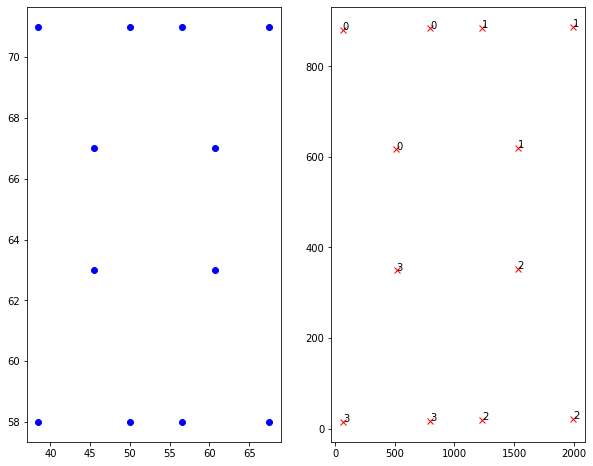

In [143]:
plt.subplot(1,2,1)
plt.plot(mmx, mmy, 'bo');
plt.subplot(1,2,2)
plt.plot(livex, livey, 'rx');
for x,y,q in zip(livex, livey, q):
    plt.text(x,y,'%i'%q)

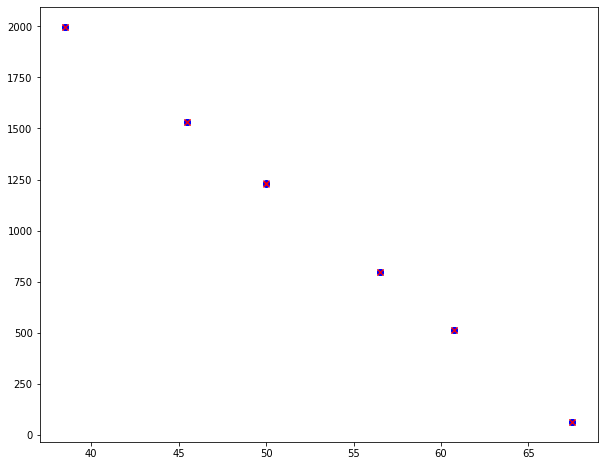

In [144]:
plt.plot(mmx, livex, 'bo');
plt.plot(mmx, px, 'rx');

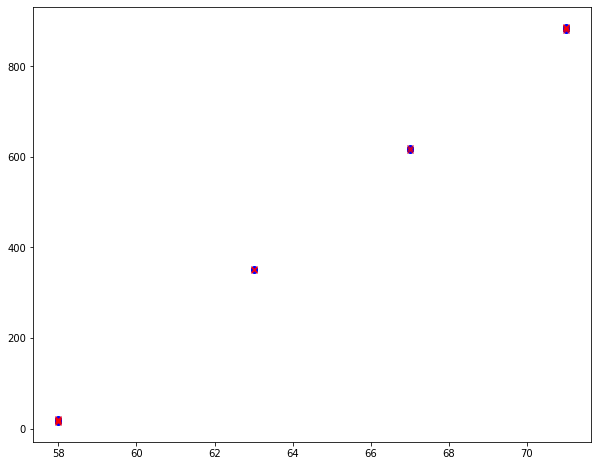

In [145]:
plt.plot(mmy, livey, 'bo');
plt.plot(mmy, py, 'rx');

In [146]:
np.mean(np.hypot(livex-px, livey-py))

0.2128030695488248

In [128]:
F = fitsio.FITS('/tmp/IMG_52.fits')

In [129]:
i1 = F[1].read()

In [130]:
i1.shape

(1056, 1106)

In [131]:
fitsio.write('/tmp/521.fits', i1)